Use 20200417 to locate each broccoli

# Clip to small parts

In [1]:
import sys
sys.path.insert(0, f'D:/OneDrive/Program/GitHub/EasyIDP')

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

from easyric.caas_lite import TiffSpliter

In [2]:
project_name = 'broccoli_tanashi_5_20200417_P4RGB_15m_M'
project_path = f"Z:/共享云端硬盘/broccoliProject/01_tanashi_broccoli2020_RGB_AP/{project_name}"
raw_img_folder=f"Z:/共享云端硬盘/broccoliProject/00_rgb_raw/{project_name}"
param_folder = f"{project_path}/params"

out_folder = f"Z:/共享云端硬盘/broccoliProject/10_anotation_use/jpg/{project_name}"
json_name = f"{out_folder}.json"

In [3]:
p4d = Pix4D(project_path=project_path, 
            raw_img_path=raw_img_folder, 
            project_name=project_name,
            param_folder=param_folder)

[Init][Pix4D] No ply given, however find 'broccoli_tanashi_5_20200417_P4RGB_15m_M_group1_densified_point_cloud.ply' at current project folder
[Init][Pix4D] No dom given, however find 'broccoli_tanashi_5_20200417_P4RGB_15m_M_transparent_mosaic_group1.tif' at current project folder
[Init][Pix4D] No dsm given, however find 'broccoli_tanashi_5_20200417_P4RGB_15m_M_dsm.tif' at current project folder
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]


In [4]:
ts = TiffSpliter(tif_path=p4d.dom_file, grid_h=1300, grid_w=1300, grid_buffer=200)

In [5]:
offset_json = {}
for w_id, w_st in enumerate(ts.wgrid_st):
    for h_id, h_st in enumerate(ts.hgrid_st):
        tiff_name = ts.id2name(w_id=w_id, h_id=h_id)
        offset_json[tiff_name] = {'x':ts.wgrid_st[w_id], 
                                  'y':ts.hgrid_st[h_id]}
ts.dict2json(offset_json, json_name)

In [6]:
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

```python
>>> ts.save_all_grids(save_folder=out_folder, extend=True, skip_empty=True, format='jpg')
grid_x11_y13.jpg | 100.0 % done | 136 s passed, 0 s left    
Cost 136 s in total
```

Then the testing data is prepared

# Broccoli detect

## Test one grid

Using GIMP to prepare training data

|foreground|background|
|---|---|
|<img src="training_data\0417fg.png">|<img src="training_data\0417bg.png">|

## Decision tree classifier

In [27]:
import skimage

from skimage.io import imsave, imread
from skimage.morphology import square
from skimage.measure import label, regionprops
from skimage.color import label2rgb, rgb2gray

In [9]:
from classifier import training_data_generate, train_model, apply_model, save_result

In [56]:
fore = imread(r'training_data\0417fg.png')
back = imread(r'training_data\0417bg.png')

In [57]:
train_img_list = [back, fore]
train_img_kind = [0, 1]

train_data, train_kind = training_data_generate(train_img_list, train_img_kind)

|--- Convert kind [0] to training data, converted shape is (57698, 6)
|--- Convert kind [1] to training data, converted shape is (5624, 6)


In [58]:
cart_clf = train_model(train_data, train_kind, classifier="CART")
cart_clf

DecisionTreeClassifier(max_depth=20)

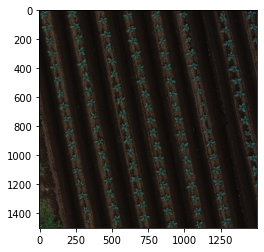

In [41]:
test_img = imread(f"{out_folder}/grid_x01_y03.jpg")
plt.imshow(test_img)

In [42]:
cart_int = apply_model(test_img, cart_clf)

In [15]:
cart_int

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

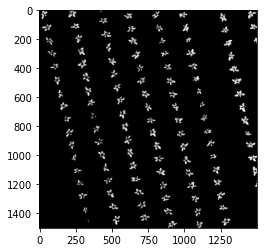

In [43]:
plt.imshow(cart_int, cmap=plt.cm.gray)

In [44]:
test_img.shape

(1500, 1500, 3)

In [45]:
alpha = cart_int * 255
alpha = alpha.astype(np.uint8)
alpha

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [46]:
png = np.concatenate([test_img, alpha.reshape(*alpha.shape, 1)], axis=2)

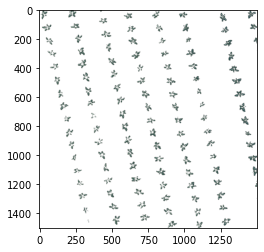

In [47]:
plt.imshow(png)

In [48]:
imsave('out/05_test.png', png)

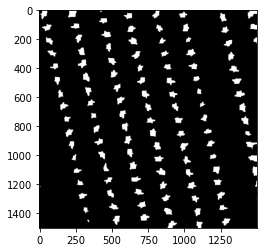

In [49]:
close_int = skimage.morphology.closing(cart_int, square(25))

plt.imshow(close_int, cmap=plt.cm.gray)

In [50]:
alpha_close = (close_int * 255).astype(np.uint8)
png_close = np.concatenate([test_img, alpha_close.reshape(*alpha_close.shape, 1)], axis=2)
imsave('out/05_test_close.png', png_close)

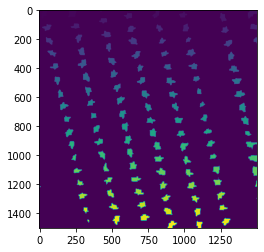

In [51]:
bro_label = label(close_int)
plt.imshow(bro_label)

In [52]:
np.unique(bro_label)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123], dtype=int64)

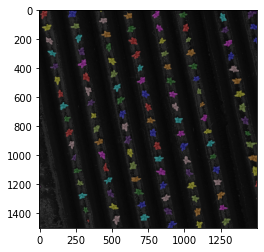

In [53]:
image_label_overlay = label2rgb(bro_label, image=test_img, bg_label=0)

plt.imshow(image_label_overlay)

In [54]:
imsave('out/05_test_close_color.png', (image_label_overlay * 255).astype(np.uint8))

## test other plots

In [30]:
import os

In [31]:
label_folder = f"Z:/共享云端硬盘/broccoliProject/10_locate_by_cv/color_label_0417"

In [62]:
total = len(os.listdir(out_folder))
count = 0
for grid_name in os.listdir(out_folder):
    count += 1
    img_full_path = os.path.join(out_folder, grid_name)
    img_array = imread(img_full_path)
    
    img_binary = apply_model(img_array, cart_clf)
    img_binary_close = skimage.morphology.closing(img_binary, square(15))
    img_binary_open = skimage.morphology.opening(img_binary_close, square(3))
    
    img_label = label(img_binary_open)
    
    image_label_overlay = label2rgb(img_label, image=img_array, bg_label=0)
    
    imsave(os.path.join(label_folder, grid_name), (image_label_overlay * 255).astype(np.uint8))
    
    print(round(count / total * 100), end='\r')

D:\Applications\Anaconda\envs\lab\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Z:/共享云端硬盘/broccoliProject/10_locate_by_cv/color_label_0417\grid_x04_y00.jpg is a low contrast image
  app.launch_new_instance()


D:\Applications\Anaconda\envs\lab\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Z:/共享云端硬盘/broccoliProject/10_locate_by_cv/color_label_0417\grid_x10_y03.jpg is a low contrast image
  app.launch_new_instance()


D:\Applications\Anaconda\envs\lab\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Z:/共享云端硬盘/broccoliProject/10_locate_by_cv/color_label_0417\grid_x10_y04.jpg is a low contrast image
  app.launch_new_instance()


D:\Applications\Anaconda\envs\lab\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Z:/共享云端硬盘/broccoliProject/10_locate_by_cv/color_label_0417\grid_x10_y12.jpg is a low contrast image
  app.launch_new_instance()
